In [1]:
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


**Data Description**

In [2]:
# open the data & drop unnamed index col
data = pd.read_csv("data_classified.csv")
data = data.drop(columns=['Unnamed: 0'], axis=1)

# limit our data to English language
data = data[data['Language']=='en']

# drop na and outlier data
data = data.dropna()
data = data[data['Retweets Count']<648678.0]

C:\Users\almag\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# show the data
data.head()

,Device,Follower Count,Following Count,Language,Likes Count,Name,Replies Count,Retweets Count,The tweet,Time,Tweet Count,Tweet ID,User Description,User ID,User Verification,Username,Sentiment
0,OppressionTrain,12.0,0.0,en,0.0,Academic Hints,0.0,0.0,Don't forget: Secretive associate professors m...,2021-07-09T20:22:00.000Z,6131.0,1.410000e+18,I'm helping.,4.497419e+09,FALSE,AcademicHints,Negative
1,OppressionTrain,12.0,0.0,en,0.0,Academic Hints,0.0,0.0,Always remember: Polite receptionists could be...,2021-07-09T12:22:00.000Z,6131.0,1.410000e+18,I'm helping.,4.497419e+09,FALSE,AcademicHints,Negative
2,OppressionTrain,12.0,0.0,en,0.0,Academic Hints,0.0,0.0,Tip of the day: Changeable campus security are...,2021-07-09T04:22:00.000Z,6131.0,1.410000e+18,I'm helping.,4.497419e+09,FALSE,AcademicHints,Negative
4,Twitter for Android,58.0,67.0,en,0.0,Ona Marija Singh,0.0,61.0,RT @BioDataGanache: Actual footage of me savin...,2021-07-09T16:19:30.000Z,155.0,1.410000e+18,"PhD student. Fly 🧚‍♀️ girl. Loves science (,) ...",2.302753e+09,FALSE,MarijaSingh,Negative
5,Twitter for Android,58.0,67.0,en,0.0,Ona Marija Singh,0.0,1.0,"RT @HansZauner: @OdedRechavi Reviewer 1: ""A br...",2021-07-09T06:16:51.000Z,155.0,1.410000e+18,"PhD student. Fly 🧚‍♀️ girl. Loves science (,) ...",2.302753e+09,FALSE,MarijaSingh,Positive


In [4]:
# unique values in the dataset
data.nunique()

Device                 113
Follower Count        6450
Following Count       1901
Language                 1
Likes Count           4309
Name                   939
Replies Count         1090
Retweets Count        3857
The tweet            80774
Time                 75642
Tweet Count           4770
Tweet ID                 2
User Description      1008
User ID                763
User Verification        4
Username               910
Sentiment                2
dtype: int64

**Data-Processing**

In [5]:
# re-format time, day and sentiment for further analysis

# sentiment in 1-0 (0-neg; 1-pos)
data['Sentiment'] = (data['Sentiment'] == 'Positive').astype('int')

# create day column to show day of month
times = list(data['Time'])
data['Day'] = times

# use time of the day (hour of the day) and day of the month
data['Time'] = data['Time'].str.slice(11, -11, 1)
data['Day'] = data['Day'].str.slice(8, 10, 1)

# turn the time and day into numerical variables
data['Time'] = pd.to_numeric(data['Time'])
data['Day'] = pd.to_numeric(data['Day'])

In [6]:
# test correlation between different times of the day and sentiment

start_time = 16
end_time = 18

print(((data['Time']>start_time) & (data['Time']<end_time)).corr(data['Sentiment']))

start_day = 22
end_day = 29

print(((data['Day']>start_day) & (data['Day']<end_day)).corr(data['Sentiment']))

-0.01750727747715677
0.009533179738735527


In [7]:
# correlation between different cols

print(data['Follower Count'].corr(data['Likes Count']))
print(data['Follower Count'].corr(data['Replies Count']))
print(data['Follower Count'].corr(data['Retweets Count']))
print(data['Day'].corr(data['Sentiment']))
print(data['Time'].corr(data['Sentiment']))
print(data['Follower Count'].corr(data['Sentiment']))

0.4346619031766286
0.26648034035412466
0.0826543691128776
-0.0027109106177769936
-0.015958971273002845
0.006177461563862424


**Visualization**

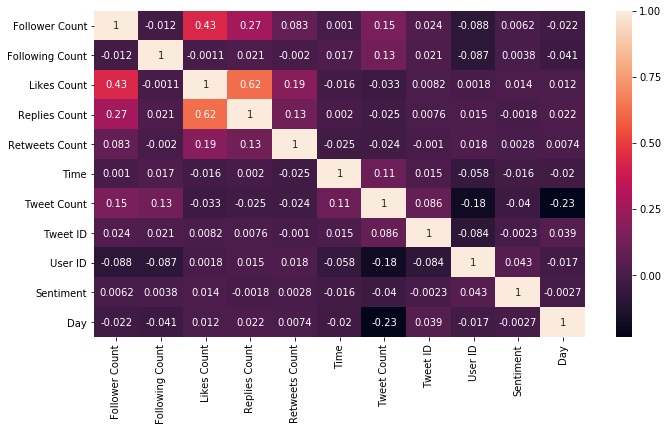

In [8]:
# plot the correlation between each column

plt.subplots(figsize=(11,6))
sns.heatmap(data.corr(), annot=True)

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


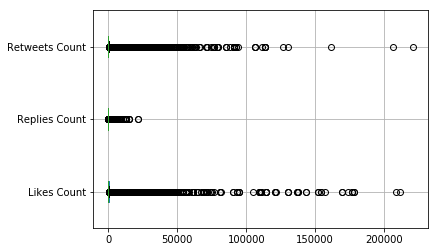

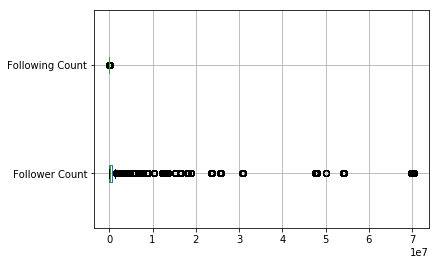

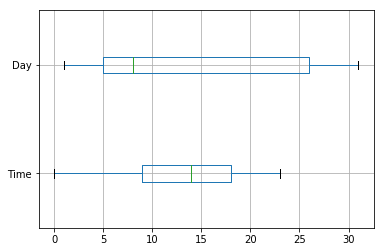

In [9]:
# observe the spread of data for the numerical variables

print(data[['Likes Count', 'Replies Count', 'Retweets Count']].plot.box(vert=False, grid=True))
print(data[['Follower Count', 'Following Count']].plot.box(vert=False, grid=True))
print(data[['Time', 'Day']].plot.box(vert=False, grid=True))

Text(0.5,1,'Tweet Count based on the hour of the day')

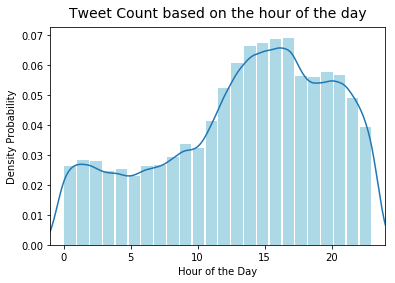

In [10]:
# distribution: tweet times of the day
fig, ax = plt.subplots(figsize = (6,4))

time_data = data['Time']

time_data.plot(kind='hist',
               bins=24, 
               rwidth=0.9,
               color='lightblue',
               density=True)
time_data.plot(kind='kde')

ax.set_xlabel('Hour of the Day')
ax.set_xlim(-1, 24)
ax.set_ylabel('Density Probability')

ax.grid(False)

ax.set_title('Tweet Count based on the hour of the day', 
             size = 14, pad = 10)


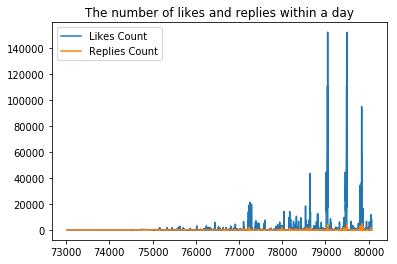

In [11]:
# visualize the likes and replies for one day


one_day = data[data['Day']==5] # for example 5 Aug

one_day.plot(y=['Likes Count', 'Replies Count'], 
            title='The number of likes and replies within a day')

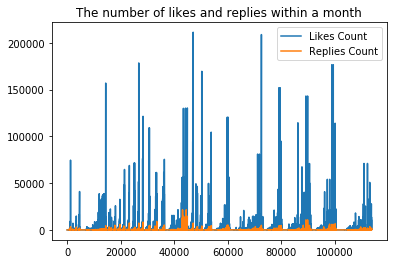

In [12]:
# visualize the likes and replies for one month
data.plot(y=['Likes Count', 'Replies Count'],
         title='The number of likes and replies within a month')

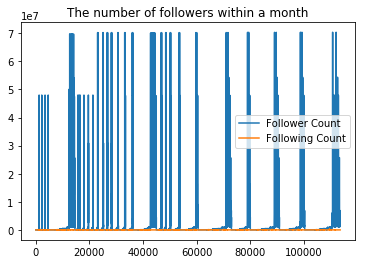

In [13]:
data.plot(y=['Follower Count', 'Following Count'],
         title = 'The number of followers within a month')

**Balance the dataset**

In [14]:
# for ML analysis, we need to balance the dataset

# check how many tweets were labelled negative and positive

len_0 = len(data[data['Sentiment']==0])
len_1 = len(data[data['Sentiment']==1])

print('Before')

print(f'Negative Sentiment',len_0)
print(f'Positive Sentiment', len_1)

Before
Negative Sentiment 68662
Positive Sentiment 33355


In [15]:
# given the imbalance, we undersample to length of positive tweets

sentiment_0 = data[data['Sentiment']==0][:len_1]
sentiment_1 = data[data['Sentiment']==1]

print('After')

print(f'Negative Sentiment', len(sentiment_0))
print(f'Positive Sentiment', len (sentiment_1))

After
Negative Sentiment 33355
Positive Sentiment 33355


In [16]:
# store the new balanced data

balanced_data_l = [sentiment_0, sentiment_1]
balanced_data = pd.concat(balanced_data_l, ignore_index=True)

len(balanced_data)

66710

In [17]:
balanced_data.tail(2)

,Device,Follower Count,Following Count,Language,Likes Count,Name,Replies Count,Retweets Count,The tweet,Time,Tweet Count,Tweet ID,User Description,User ID,User Verification,Username,Sentiment,Day
66708,Twitter Media Studio,4490123.0,5402.0,en,4202.0,Ted Cruz,1545.0,705.0,Dr. Fauci is a political player who says what ...,14,32539.0,1.420000e+18,"Father of two, @heidiscruz's husband, fighter ...",23022687.0,True,tedcruz,1,8
66709,Twitter for iPhone,4490123.0,5402.0,en,0.0,Ted Cruz,0.0,235.0,RT @JoeTalkShow: It's about power and control....,0,32539.0,1.420000e+18,"Father of two, @heidiscruz's husband, fighter ...",23022687.0,True,tedcruz,1,8


**Data Analysis**

**Binary Classification**

In [18]:
def confusion_matrix_plot(Y_test, Y_pred):
    '''
    Plots confusion matrix.
    '''
    confusion = confusion_matrix(Y_test, Y_pred)
    class_names=['Negative', 'Positive'] 

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))

    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt="g")
    ax.xaxis.set_label_position("top")

    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [19]:
def model_scores(model, X, Y):
    '''
    Trains & Assesses the model.
    '''
    print('Model:', (str(model)))
    print('Predictor:', X)
    print('Predicted:', Y)
    print('--------------------------------------------------------')
    # preprocess the data 
    X = np.array((balanced_data[X])).reshape(-1,1)
    Y = np.array((balanced_data[Y])).reshape(-1,1).ravel()
    
    # split for training
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                        test_size=0.1, 
                                                        shuffle=True, 
                                                        random_state=0)
    
    # specify & train the model
    m = model
    m.fit(X_train, Y_train)
    
    # cross validate
    cv_scores = cross_val_score(m, X_train, Y_train, cv=100)
    print('Cross-Validation Max score:', max(cv_scores))
    print('--------------------------------------------------------')
    
    # check the accuracy
    Y_pred = m.predict(X_test)
    print('Classification Report:', metrics.classification_report(Y_test, Y_pred))
    print('--------------------------------------------------------')
    # print confusion matrix
    
    return confusion_matrix_plot(Y_test, Y_pred)

Model: LogisticRegression()
Predictor: Day
Predicted: Sentiment
--------------------------------------------------------
Cross-Validation Max score: 0.718801996672213
--------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.65      0.64      0.65      3235
           1       0.67      0.67      0.67      3436

    accuracy                           0.66      6671
   macro avg       0.66      0.66      0.66      6671
weighted avg       0.66      0.66      0.66      6671

--------------------------------------------------------


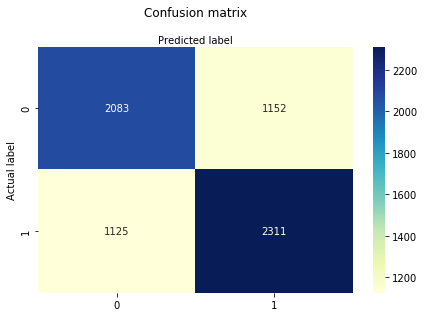

In [20]:
model_scores(model=LogisticRegression(), X='Day',Y='Sentiment')

Model: LogisticRegression()
Predictor: Time
Predicted: Sentiment
--------------------------------------------------------
Cross-Validation Max score: 0.540765391014975
--------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.50      0.86      0.63      3235
           1       0.58      0.19      0.28      3436

    accuracy                           0.51      6671
   macro avg       0.54      0.52      0.46      6671
weighted avg       0.54      0.51      0.45      6671

--------------------------------------------------------


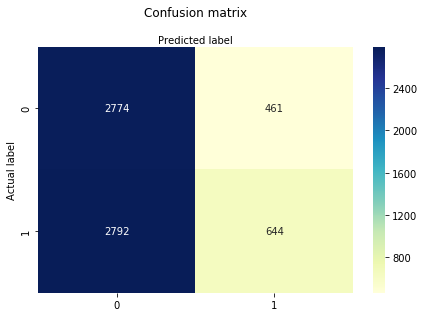

In [21]:
model_scores(model=LogisticRegression(), X='Time',Y='Sentiment')

Model: LogisticRegression()
Predictor: Likes Count
Predicted: Sentiment
--------------------------------------------------------
Cross-Validation Max score: 0.5266666666666666
--------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.48      0.40      0.44      3235
           1       0.51      0.58      0.54      3436

    accuracy                           0.49      6671
   macro avg       0.49      0.49      0.49      6671
weighted avg       0.49      0.49      0.49      6671

--------------------------------------------------------


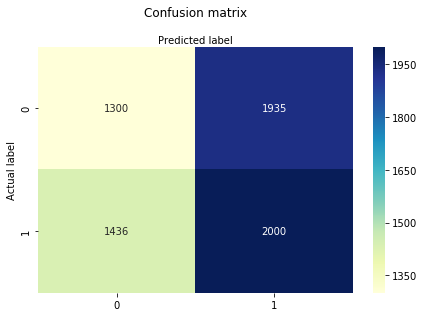

In [22]:
model_scores(model=LogisticRegression(), X='Likes Count',Y='Sentiment')

Model: LogisticRegression()
Predictor: Follower Count
Predicted: Sentiment
--------------------------------------------------------
Cross-Validation Max score: 0.5033333333333333
--------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.65      0.00      0.01      3235
           1       0.52      1.00      0.68      3436

    accuracy                           0.52      6671
   macro avg       0.58      0.50      0.34      6671
weighted avg       0.58      0.52      0.35      6671

--------------------------------------------------------


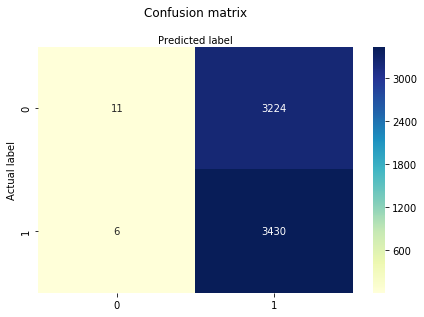

In [23]:
model_scores(model=LogisticRegression(), X='Follower Count',Y='Sentiment')

Model: LogisticRegression()
Predictor: Following Count
Predicted: Sentiment
--------------------------------------------------------
Cross-Validation Max score: 0.5066666666666667
--------------------------------------------------------
Classification Report:               precision    recall  f1-score   support

           0       0.35      0.01      0.02      3235
           1       0.51      0.98      0.67      3436

    accuracy                           0.51      6671
   macro avg       0.43      0.50      0.35      6671
weighted avg       0.44      0.51      0.36      6671

--------------------------------------------------------


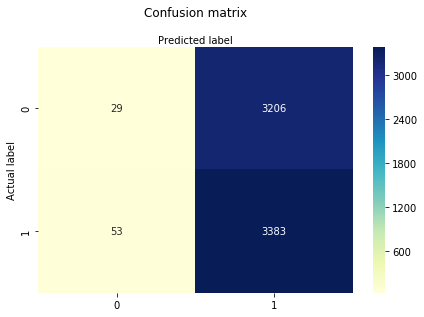

In [24]:
model_scores(model=LogisticRegression(), X='Following Count',Y='Sentiment')

**Linear Regression**

In [25]:
train_mr, test_mr = train_test_split(balanced_data, train_size = 0.9, test_size = 0.1, random_state = 100)

scaler = MinMaxScaler()

cols = ['Tweet Count', 'Likes Count']
train_mr[cols] = scaler.fit_transform(train_mr[cols])
train_mr = train_mr[cols]

C:\Users\almag\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\almag\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [26]:
y_train = train_mr.pop('Likes Count')
y_train = np.array(y_train)
X_train = np.array(train_mr)

In [27]:
X_train_lm = sm.add_constant(X_train)

lr_1 = sm.OLS(y_train, X_train_lm).fit()

lr_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     41.99
Date:                Mon, 23 Aug 2021   Prob (F-statistic):           9.24e-11
Time:                        22:47:57   Log-Likelihood:             1.4793e+05
No. Observations:               60039   AIC:                        -2.959e+05
Df Residuals:                   60037   BIC:                        -2.958e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027   9.63e-05     27.676      0.000       0.002       0.003
x1            -0.0061      0.001     -6.480      0.000      -0.008      -0.004
==============================================================================
Omnibus:                   140719.998   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       1405369906.469
Skew:                          23.550   Prob(JB):                         0.00
Kurtosis:                     751.040   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
from numpy import loadtxt
from keras.models import Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler

In [29]:
def neural_network_classification (x, y, m, dims, epoch):
    
    ''' This function uses neural networks to classify data.'''
    
    # preprocessing
    
    features = balanced_data[x]
    labels = balanced_data[y]
    
    X = features
    Y = np.ravel(labels)
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.33, random_state=42)
    
    #rescaling
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # model selection
    
    model = m
    
    # fine-tuning

    model.add(Dense(64, input_dim=dims, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    # run the model
    history = model.fit(X_train, Y_train, epochs=epoch, batch_size=168, verbose=1)
    
    # evaluate the scores in test data
    y_pred = model.predict(X_test)

    score = model.evaluate(X_test, Y_test,verbose=1)
    
    # show the results over time
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['loss'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'loss'], loc='upper left')
    plt.show()

    return score

Epoch 1/25
267/267 [==============================] - 2s 3ms/step - loss: 0.6804 - accuracy: 0.5617
Epoch 2/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6283 - accuracy: 0.6912: 0s - loss: 0.6287 - accuracy: 0.
Epoch 3/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6125 - accuracy: 0.7036
Epoch 4/25
267/267 [==============================] - 1s 3ms/step - loss: 0.5908 - accuracy: 0.7130
Epoch 5/25
267/267 [==============================] - 1s 3ms/step - loss: 0.5672 - accuracy: 0.7147
Epoch 6/25
267/267 [==============================] - 1s 3ms/step - loss: 0.5495 - accuracy: 0.7181
Epoch 7/25
267/267 [==============================] - 1s 3ms/step - loss: 0.5359 - accuracy: 0.7220
Epoch 8/25
267/267 [==============================] - 1s 3ms/step - loss: 0.5247 - accuracy: 0.7259
Epoch 9/25
267/267 [==============================] - 1s 3ms/step - loss: 0.5189 - accuracy: 0.7312
Epoch 10/25
267/267 [==============================] - 1s 3ms/step

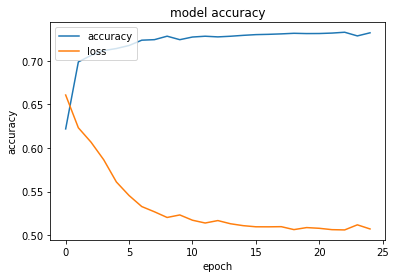

[0.49539974331855774, 0.7396320700645447]

In [30]:
neural_network_classification (x=['Day', 'Time'], y=['Sentiment'], m=Sequential(), dims=2, epoch=25)

Epoch 1/25
267/267 [==============================] - 2s 4ms/step - loss: 0.6663 - accuracy: 0.6051
Epoch 2/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6193 - accuracy: 0.7069
Epoch 3/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6024 - accuracy: 0.7121
Epoch 4/25
267/267 [==============================] - 1s 3ms/step - loss: 0.5784 - accuracy: 0.7110
Epoch 5/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5494 - accuracy: 0.7147
Epoch 6/25
267/267 [==============================] - 1s 3ms/step - loss: 0.5387 - accuracy: 0.7157
Epoch 7/25
267/267 [==============================] - 1s 3ms/step - loss: 0.5266 - accuracy: 0.7254
Epoch 8/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5233 - accuracy: 0.7298
Epoch 9/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5173 - accuracy: 0.7315
Epoch 10/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5150 - accuracy: 0.7284

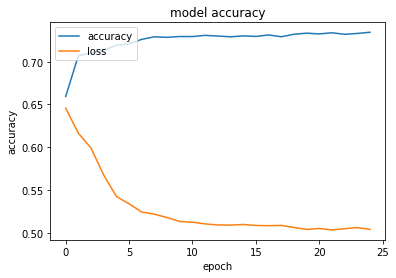

[0.494753897190094, 0.7396320700645447]

In [31]:
neural_network_classification (x=['Day'], y=['Sentiment'], m=Sequential(), dims=1, epoch=25)

Epoch 1/25
267/267 [==============================] - 2s 4ms/step - loss: 0.6674 - accuracy: 0.6094
Epoch 2/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6257 - accuracy: 0.7035
Epoch 3/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6137 - accuracy: 0.7075
Epoch 4/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5967 - accuracy: 0.7113
Epoch 5/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5754 - accuracy: 0.7052
Epoch 6/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5486 - accuracy: 0.7135
Epoch 7/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5393 - accuracy: 0.7151
Epoch 8/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5270 - accuracy: 0.7216
Epoch 9/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5236 - accuracy: 0.7256
Epoch 10/25
267/267 [==============================] - 1s 4ms/step - loss: 0.5247 - accuracy: 0.7228

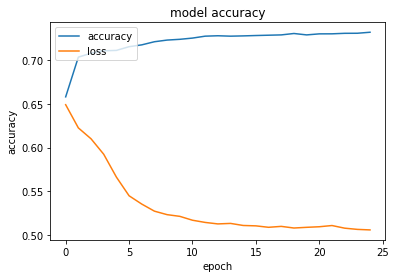

[0.49580278992652893, 0.7389507293701172]

In [32]:
neural_network_classification (x=['Day', 'Likes Count', 'Replies Count'], y=['Sentiment'], m=Sequential(), dims=3, epoch=25)

Epoch 1/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6965 - accuracy: 0.4975
Epoch 2/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6940 - accuracy: 0.4988
Epoch 3/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6939 - accuracy: 0.4977
Epoch 4/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.5002
Epoch 5/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.4997
Epoch 6/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 0.4974
Epoch 7/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.4969
Epoch 8/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.5026
Epoch 9/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6933 - accuracy: 0.5004
Epoch 10/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6931 - accuracy: 0.4997

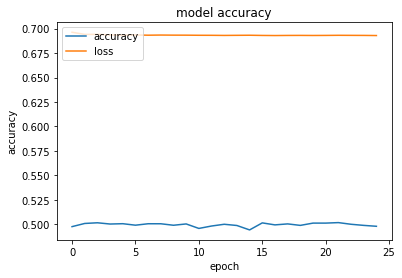

[0.692944347858429, 0.5006586313247681]

In [33]:
neural_network_classification (x=['Likes Count', 'Replies Count'], y=['Sentiment'], m=Sequential(), dims=2, epoch=25)

Epoch 1/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6952 - accuracy: 0.5141
Epoch 2/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6859 - accuracy: 0.5645
Epoch 3/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6836 - accuracy: 0.5749
Epoch 4/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6833 - accuracy: 0.5720
Epoch 5/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6815 - accuracy: 0.5755
Epoch 6/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6798 - accuracy: 0.5747
Epoch 7/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6805 - accuracy: 0.5711
Epoch 8/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6804 - accuracy: 0.5720
Epoch 9/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6786 - accuracy: 0.5773
Epoch 10/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6792 - accuracy: 0.5743

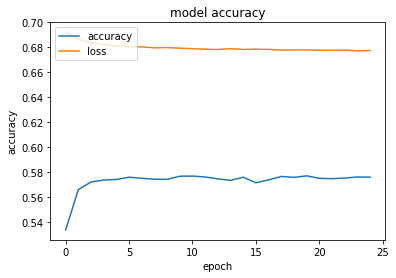

[0.673638641834259, 0.5827390551567078]

In [34]:
neural_network_classification (x=['Tweet Count', 'Follower Count'], y=['Sentiment'], m=Sequential(), dims=2, epoch=25)

Epoch 1/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6995 - accuracy: 0.4984
Epoch 2/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6938 - accuracy: 0.5040
Epoch 3/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6941 - accuracy: 0.4981
Epoch 4/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6936 - accuracy: 0.5019
Epoch 5/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.5048
Epoch 6/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6933 - accuracy: 0.5026
Epoch 7/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6934 - accuracy: 0.5047
Epoch 8/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.5076
Epoch 9/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.5051
Epoch 10/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.5160

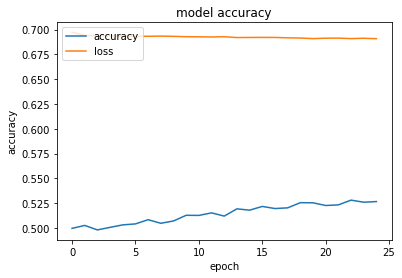

[0.6898515820503235, 0.5188280940055847]

In [35]:
neural_network_classification (x=['Retweets Count', 'Follower Count'], y=['Sentiment'], m=Sequential(), dims=2, epoch=25)

Epoch 1/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6911 - accuracy: 0.5264
Epoch 2/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6838 - accuracy: 0.5665
Epoch 3/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6824 - accuracy: 0.5703
Epoch 4/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6815 - accuracy: 0.5721
Epoch 5/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6790 - accuracy: 0.5800
Epoch 6/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6806 - accuracy: 0.5749
Epoch 7/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6814 - accuracy: 0.5728
Epoch 8/25
267/267 [==============================] - 1s 3ms/step - loss: 0.6793 - accuracy: 0.5782
Epoch 9/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6792 - accuracy: 0.5743
Epoch 10/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6798 - accuracy: 0.5707

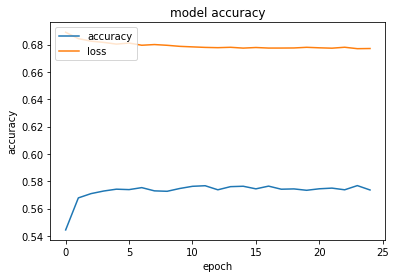

[0.6733306646347046, 0.5782421231269836]

In [36]:
neural_network_classification (x=['Tweet Count'], y=['Sentiment'], m=Sequential(), dims=1, epoch=25)

Epoch 1/25
267/267 [==============================] - 2s 4ms/step - loss: 0.6966 - accuracy: 0.5003
Epoch 2/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6938 - accuracy: 0.5011
Epoch 3/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6938 - accuracy: 0.5024
Epoch 4/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6937 - accuracy: 0.4997
Epoch 5/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 0.5018
Epoch 6/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6930 - accuracy: 0.4996
Epoch 7/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5032
Epoch 8/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 0.5071
Epoch 9/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6932 - accuracy: 0.5073
Epoch 10/25
267/267 [==============================] - 1s 4ms/step - loss: 0.6931 - accuracy: 0.5019

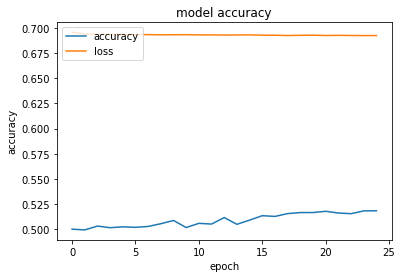

[0.691704511642456, 0.5286849737167358]

In [37]:
neural_network_classification (x=['Follower Count'], y=['Sentiment'], m=Sequential(), dims=1, epoch=25)